In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid
import pickle
from tqdm import tqdm, trange

from LIMxCMBL.experiments import *
import matplotlib.pyplot as plt 

/home/users/delon/.local/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


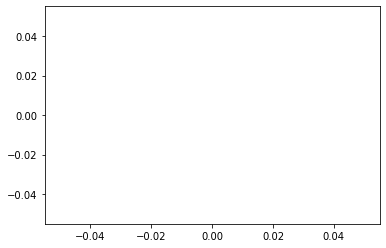

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1,
    'figure.figsize': (6, 6/1.618),
    'figure.constrained_layout.use': True,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})


In [3]:
e_order = ['CHIME',
          'HETDEX',
          'COMAP',
        'CCAT-prime',
           'SPHEREx',]

e_colors = {
    'CHIME': '#8932B8',
    'HETDEX': '#3C44AA',
    'COMAP': '#5E7C16',
    'SPHEREx': '#B02E26',
    'CCAT-prime':'#F9801D',
}

In [4]:
kpar_funds = []
for experiment in e_order:
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)
    kpar_funds += [[kpar_fundamental, experiment]]
    
kpar_funds = list(reversed(sorted(kpar_funds)))

In [5]:
import matplotlib.patheffects as pe

In [6]:
N0_fname = 'N0_so'

In [7]:
_oup_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.008_'+N0_fname+'_'

In [8]:
def hline_text(x, y, text, color="k", fontsize=12, linestyle="-", ax=None,
              left = None, right = None, path_effects = None, ha='right', lw=1,
              pad = .01):
    """ draw hline at y interrupted by text at x """
    if ax is None:
        ax = plt.gca()
    text += ' '
    text = ' ' + text
    label = ax.text(x, y, text, color='k', fontsize=fontsize,
                    va="center", ha=ha,
                   path_effects= path_effects)
    # draw text to get its bounding box
    ax.get_figure().canvas.draw()
    bbox = label.get_window_extent().transformed(ax.transAxes.inverted())
    bbox.x0 -= pad
    bbox.x1 += pad
    bbox = bbox.transformed(ax.transAxes).transformed(ax.transData.inverted())
    # add hlines next to bounding box
    if(left == None):
        left, right = ax.get_xlim()
    ax.hlines([y]*2, [left, bbox.x1], [bbox.x0, right], color=color, linestyle=linestyle, lw=lw)

In [9]:
e_order = ['HETDEX',
          'CHIME',
          'COMAP',
        'CCAT-prime',
           'SPHEREx',]

e_colors = {
    'CHIME': '#8932B8',
    'HETDEX': '#3C44AA',
    'COMAP': '#5E7C16',
    'SPHEREx': '#B02E26',
    'CCAT-prime':'#F9801D',
}

HETDEX (9,)
CHIME (7,)
COMAP (8,)
CCAT-prime (10,)
SPHEREx (8,)


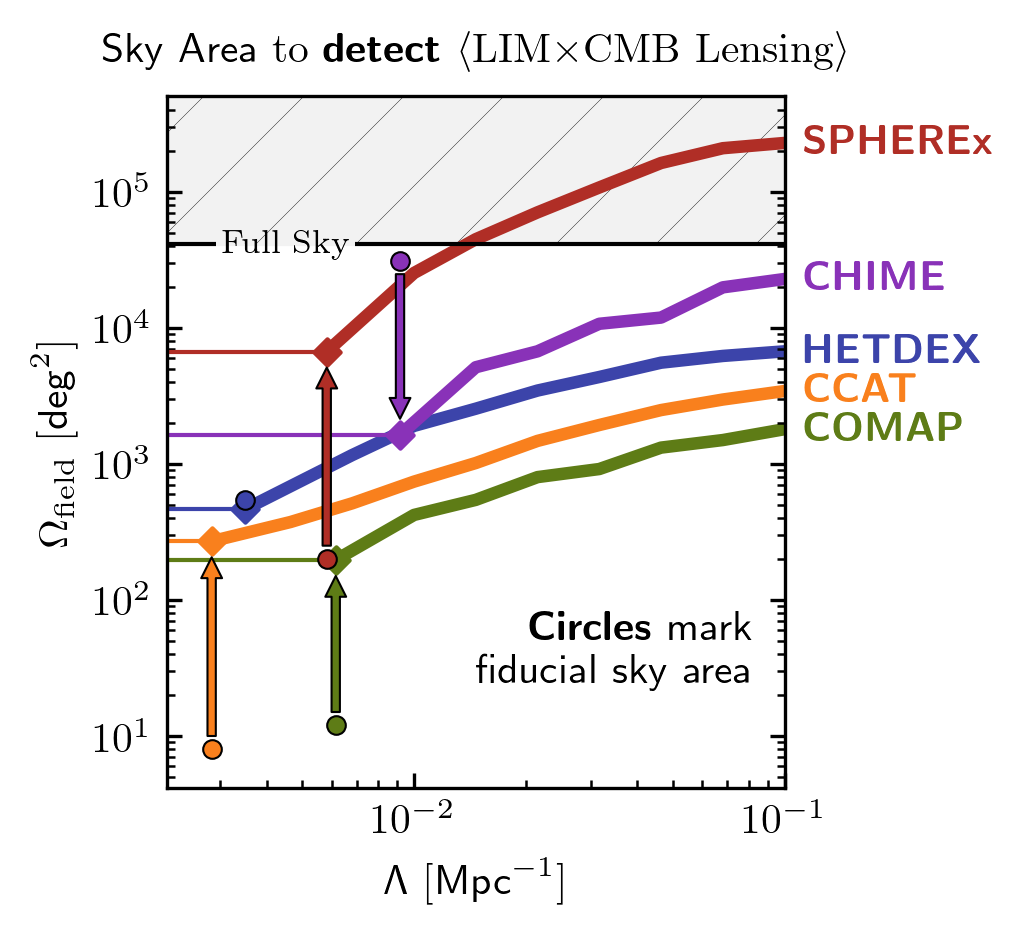

In [10]:
xmin = Lambdas[14]

plt.figure(figsize = (3.3, 3), facecolor = 'w', dpi = 300)
sval = '0.95'

fullsky_deg2 = 4 * np.pi * (180/np.pi)**2
plt.axhspan(fullsky_deg2, fullsky_deg2*100, color=sval, label='No Detection')
plt.axhspan(fullsky_deg2, fullsky_deg2*100, alpha=1, facecolor="None", hatch='/',
            rasterized=True,
                                     linewidth=0,
                                     edgecolor="k")




for experiment in e_order:
    #metadata
    c = e_colors[experiment]
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']
    
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)
    SNR2_per_mode_full = {}

    __oup_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.007_'+N0_fname+'_'
    with open(__oup_fname+experiment+'_full.pkl', 'rb') as f:
        SNR2_per_mode_full=pickle.load(f)
    _Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))


    deg2_needed = -1
    
    with open(_oup_fname+experiment+'_full_deg2_detect.pkl', 'rb') as f:
        deg2_needed = pickle.load(f)
        
        
        
    #plotting snr
    print(experiment, deg2_needed.shape)
    plt.plot(np.hstack(([kpar_fundamental], _Lambdas[1:])),
             deg2_needed,
             c=c, ls='-', lw=3,
             zorder=1,
            label=r'\textsf{%s}'%experiment)

    unfiltered_deg2_needed = deg2_needed[0]
    plt.plot([0, kpar_fundamental], 
             [unfiltered_deg2_needed, unfiltered_deg2_needed],
             c=c, lw=1,)

    plt.scatter([kpar_fundamental], [unfiltered_deg2_needed],
                marker='D',
                s=20,
                c=c,
                zorder=3,
               )
    
    Omega_field  =  np.array(experiments[experiment]['Omega_field'].to(u.deg**2)) #rad^2
#     plt.axhline(Omega_field, c=c, lw=1, ls='--')
    plt.scatter([kpar_fundamental], [Omega_field],
                marker='o',
                s=20,
                c=c,
                lw=0.5,
                edgecolor='k',
                zorder=3,
               )

    xy = (kpar_fundamental, unfiltered_deg2_needed * np.exp(-0.13))
    xytext=(kpar_fundamental, Omega_field * np.exp(-0.4))
    
    if(experiment == 'CHIME'):
        xy = (kpar_fundamental, unfiltered_deg2_needed * np.exp(+0.13))
        xytext=(kpar_fundamental, Omega_field * np.exp(+0.4))
    

    if(experiment != 'HETDEX'):
        plt.annotate(r'\textbf{\textsf{}}', xy=xy, 
                     xytext = xytext,
                     arrowprops=dict(arrowstyle= 'simple',
                                     facecolor=c,
                                     mutation_scale=10,
                                     lw=0.5,
                                     ls='-'),
                     ha='center', va='center', fontsize=11, color=c)

    
    texty = deg2_needed[-1]
    

    _etxt = experiment
    if(experiment == 'CCAT-prime'):
        _etxt = 'CCAT'
    plt.text(x = 1.13e-1, y= texty, 
             s=r'\textsf{\textbf{%s}}'%_etxt,
             horizontalalignment='left',
             fontsize=10,
             color=e_colors[experiment],
             verticalalignment='center')
    


    
# axes
plt.xlim(xmin, 1e-1)
plt.xscale('log')
plt.yscale('log')
plt.ylim(None, 5e5)

plt.xlabel(r'${\sf\Lambda}\ [{\sf Mpc}^{-1}]$')

# # plt.ylim(5e-2, 3e1)
plt.ylabel(r'$\Omega_{\rm field}$ [${\sf deg}^2$]')


plt.text(x=0.5,
        y=1 + 0.0375,
        s=r'{\sf Sky Area} to \textbf{\textsf{detect}} $\langle$LIM$\times$CMB Lensing$\rangle$',
        verticalalignment='bottom',
        horizontalalignment='center',
         transform=plt.gca().transAxes,
         linespacing = 1+.25,
         fontsize=10,)




hline_text(x=4.5e-3, y=fullsky_deg2, text='Full Sky', lw=1,
           color='k', fontsize=8, linestyle='-',
           ha = 'center', pad=0.009)


_s = r"\textsf{\textbf{Circles} mark}"
_s += '\n' 
_s += r"\textsf{{{fiducial}} {sky area}}"

plt.text(0.95,0.2, _s,
        verticalalignment='center',
        horizontalalignment='right',
         fontsize=10,
        transform=plt.gca().transAxes)

plt.gca().tick_params(axis='y', which='both', right=True, zorder=10)


plt.savefig('figures/011.008.Ofield_detect.pdf', bbox_inches='tight')
